In [1]:
import kagglehub
import shutil
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE

In [2]:
# Descarga el dataset si no existe en la carpeta data
dataset_final_path = "data/EuroSAT/"

if os.path.exists(dataset_final_path):
    print("El dataset ya está descargado. No es necesario volver a descargarlo")
else:
    print("Descargando el dataset...")
    download_path = kagglehub.dataset_download("apollo2506/eurosat-dataset")
    original_path = os.path.join(download_path, "EuroSAT")

    # Verifica que la carpeta EuroSAT existe en el dataset descargado
    if os.path.exists(original_path):
        # Mueve la carpeta EuroSAT a data
        shutil.move(original_path, dataset_final_path)
        print(f"Dataset movido a: {dataset_final_path}")
    else:
        print("Error: No se encontró la carpeta EuroSAT dentro del dataset")

El dataset ya está descargado. No es necesario volver a descargarlo


In [3]:
# Mapeo de etiquetas desde el fichero label_map.json
label_map_path = os.path.join(dataset_final_path, "label_map.json")

with open(label_map_path, "r") as file:
    label_map = json.load(file)

print("Etiquetas:", label_map)

Etiquetas: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [4]:
# Extracción de características Haralick, HOG y LBP de las imágenes

# Ref. https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycomatrix
# Ref. https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycoprops
# Ref. https://medium.com/top-python-libraries/12-examples-of-image-texture-analysis-in-python-6cf7c179ada7
# Ref. https://medium.com/@girishajmera/feature-extraction-of-images-using-glcm-gray-level-cooccurrence-matrix-e4bda8729498
# Ref. https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8

# Parámetros para calcular la matriz de co-ocurrencia de niveles de gris (GLCM)
distances = [1]  # Distancia de 1 píxel entre los valores a comparar
angles = [0]  # Ángulo de 0 grados (horizontal) para evaluar la textura

X_haralick, X_hog, X_lbp, X_combined, y = [], [], [], [], []

# Recorre todas las carpetas dentro del dataset
for class_name, label in label_map.items():

    class_path = os.path.join(dataset_final_path, class_name)

    if not os.path.isdir(class_path):
        continue  # Si no es una carpeta válida se ignora

    print(f"Procesando: {class_name}")

    # Recorre todas las imágenes dentro de la carpeta actual
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Carga la imagen en escala de grises
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Si la imagen no se puede leer se ignora
        if img is None:
            continue

        # Calcula la matriz de co-ocurrencia de niveles de gris (GLCM)
        glcm = graycomatrix(img, distances, angles, symmetric=True, normed=True)

        # Extracción de características de Haralick
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        asm = graycoprops(glcm, 'ASM')[0, 0]
        haralick_features = [contrast, dissimilarity, homogeneity, energy, correlation, asm]

        # Extracción de características usando el histograma de gradientes orientados (HOG)
        hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        # Extracción de características usando Local Binary Patterns (LBP)
        lbp_features = local_binary_pattern(img, P=8, R=1).flatten()

        # Almaceno las características en listas separadas
        X_haralick.append(haralick_features)
        X_hog.append(list(hog_features))
        X_lbp.append(list(lbp_features))
        X_combined.append(haralick_features + list(hog_features) + list(lbp_features))
        y.append(label)

print("Extracción de características completada")

Procesando: AnnualCrop
Procesando: Forest
Procesando: HerbaceousVegetation
Procesando: Highway
Procesando: Industrial
Procesando: Pasture
Procesando: PermanentCrop
Procesando: Residential
Procesando: River
Procesando: SeaLake
Extracción de características completada


In [5]:
# Convierte los datos en arrays
X_haralick = np.array(X_haralick)
X_hog = np.array(X_hog)
X_lbp = np.array(X_lbp)
X_combined = np.array(X_combined)
y = np.array(y)

Distribución de clases: Counter({0: 3000, 1: 3000, 2: 3000, 7: 3000, 9: 3000, 3: 2500, 4: 2500, 6: 2500, 8: 2500, 5: 2000})


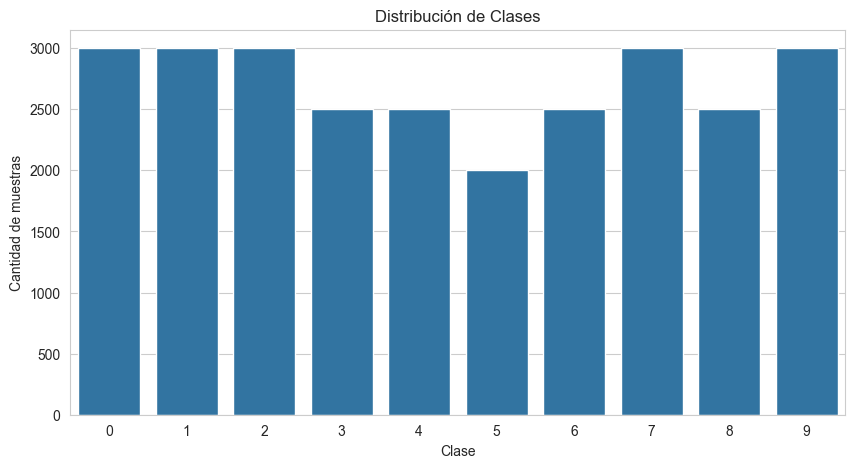

In [6]:
# Visualizar la distribución de clases
counter = Counter(y)
print("Distribución de clases:", counter)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(counter.keys()), y=list(counter.values()))
plt.xlabel("Clase")
plt.ylabel("Cantidad de muestras")
plt.title("Distribución de Clases")
plt.xticks(rotation=0)
plt.show()

In [7]:
# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)
X_haralick_resampled, y_resampled = smote.fit_resample(X_haralick, y)
X_hog_resampled, _ = smote.fit_resample(X_hog, y)
X_lbp_resampled, _ = smote.fit_resample(X_lbp, y)
X_combined_resampled, _ = smote.fit_resample(X_combined, y)

In [8]:
# Función para entrenar el modelo con diferentes características
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    svm = SVC(kernel='linear', class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return X_train, X_test, y_train, y_test, y_pred

In [15]:
# Función para evaluar el modelo

# Ref. https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def evaluate_model(y_test, y_pred, feature_name, X_train, y_train):
    print(f"Resultados para {feature_name}:")
    print(classification_report(y_test, y_pred))

    train_sizes, train_scores, test_scores = learning_curve( # Analiza cómo varía la precisión al entrenar con diferentes cantidades de datos
        SVC(kernel='linear', class_weight='balanced'),
        X_train, y_train,
        # cv=3,
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 3),  # Reduce aún más el número de pruebas → [0.1, 0.55, 1.0]
        n_jobs=-1  # Usa todos los núcleos disponibles de la CPU para paralelizar el cálculo
    )

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Entrenamiento")
    plt.plot(train_sizes, test_scores.mean(axis=1), label="Validación")
    plt.xlabel("Cantidad de Datos")
    plt.ylabel("Precisión")
    plt.legend()
    plt.title(f"Curva de Aprendizaje - {feature_name}")
    plt.show()

In [10]:
# Entrenamiento con Haralick (GLCM)
X_train_haralick, X_test_haralick, y_train_haralick, y_test_haralick, y_pred_haralick = train_model(
    X_haralick_resampled, y_resampled)

In [11]:
# Entrenamiento con HOG
X_train_hog, X_test_hog, y_train_hog, y_test_hog, y_pred_hog = train_model(X_hog_resampled, y_resampled)

In [12]:
# Entrenamiento con LBP
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp, y_pred_lbp = train_model(X_lbp_resampled, y_resampled)

In [13]:
# Entrenamiento combinando todos los extractores de características
X_train_combined, X_test_combined, y_train_combined, y_test_combined, y_pred_combined = train_model(
    X_combined_resampled, y_resampled)

In [ ]:
# Evaluación de Haralick (GLCM)
evaluate_model(y_test_haralick, y_pred_haralick, "Haralick (GLCM)", X_train_haralick, y_train_haralick)

Resultados para Haralick (GLCM):
              precision    recall  f1-score   support

           0       0.61      0.74      0.67       567
           1       0.88      0.88      0.88       612
           2       0.51      0.51      0.51       609
           3       0.42      0.23      0.30       629
           4       0.82      0.90      0.86       605
           5       0.58      0.70      0.64       606
           6       0.42      0.53      0.47       565
           7       0.85      0.91      0.88       595
           8       0.71      0.43      0.53       594
           9       0.95      0.97      0.96       618

    accuracy                           0.68      6000
   macro avg       0.67      0.68      0.67      6000
weighted avg       0.68      0.68      0.67      6000



In [ ]:
# Evaluación de HOG
# evaluate_model(y_test_hog, y_pred_hog, "HOG", X_train_hog, y_resampled)

In [ ]:
# Evaluación de LBP
# evaluate_model(y_test_lbp, y_pred_lbp, "LBP", X_train_lbp, y_resampled)

In [ ]:
# Evaluación combinada de todos los extractores de características
# evaluate_model(y_test_combined, y_pred_combined, "Haralick + HOG + LBP", X_train_combined, y_resampled)